## visualize all 36 results

In [34]:
from nltk.stem import WordNetLemmatizer
word = "absence"
lemmatizer = WordNetLemmatizer()
lemmatizer.lemmatize(word.lower())

'absence'

In [37]:
import unicodedata
import re

def normalize(text, lang="German"):
    """ Normalize text: lowercasing, unicode normalize, replace ß with ss, remove accents """
    text = text.lower().strip()
    text = text.replace("ß", "ss")
    text = text.replace("ä", "ae").replace("ö", "oe").replace("ü", "ue")
    # Remove accents
    text = unicodedata.normalize("NFKD", text)
    text = "".join(c for c in text if not unicodedata.combining(c))
    return text

def is_match(output, targets, lang="German"):
    norm_output = normalize(output, lang)
    for target in targets:
        norm_target = normalize(target, lang)
        # Exact match or substring match
        if norm_target in norm_output or norm_output in norm_target:
            return True
    return False

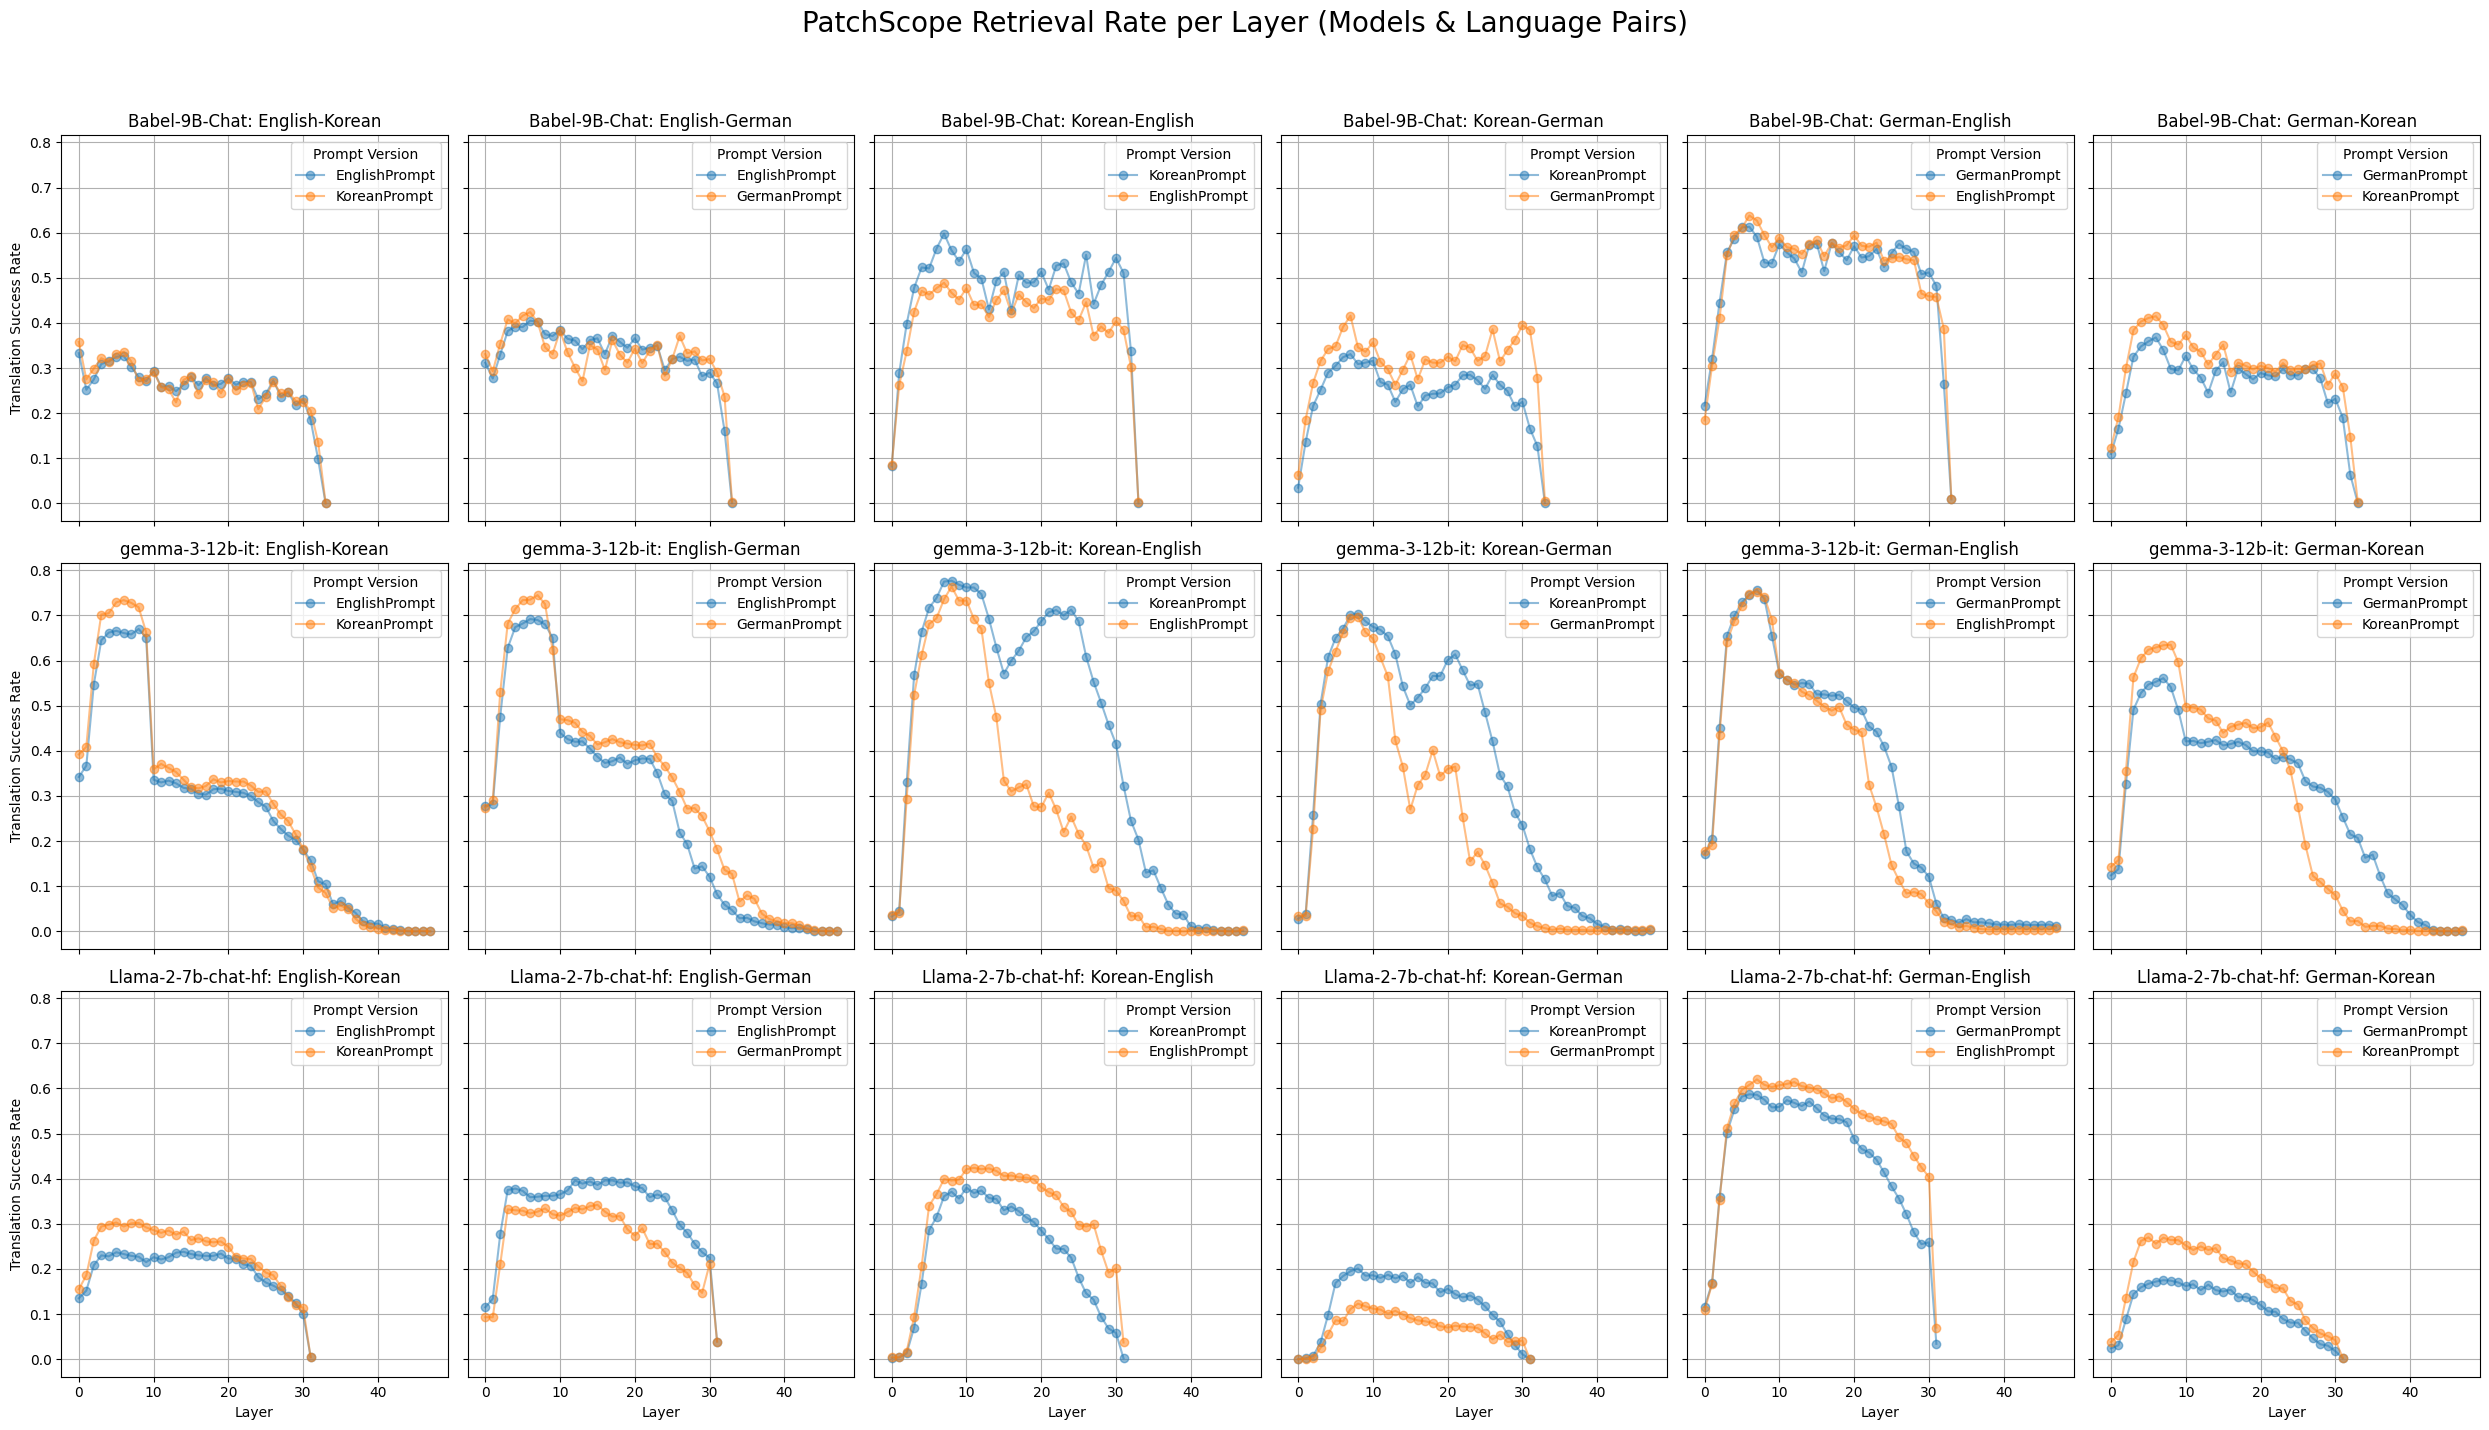

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval

# Define models, languages, and prompt versions
models = ["Tower-Babel/Babel-9B-Chat", "google/gemma-3-12b-it", "meta-llama/Llama-2-7b-chat-hf"]
languages = ["English", "Korean", "German"]
language_pairs = [(src, tgt) for src in languages for tgt in languages if src != tgt]

# Define colors and line styles for visualization

# Create subplots
fig, axes = plt.subplots(len(models), len(language_pairs), figsize=(25, 15), sharex=True, sharey=True)
fig.suptitle("PatchScope Retrieval Rate per Layer (Models & Language Pairs)", fontsize=20)

for i, model in enumerate(models):
    model_short = model.split("/")[-1]
    for j, (src, tgt) in enumerate(language_pairs):
        ax = axes[i, j]
        prompt_versions = [f"{src}Prompt", f"{tgt}Prompt"]
        for prompt_version in prompt_versions:
            try:
                # Load dataset
                data_df = pd.read_csv(f"/home/hyujang/multilingual-inner-lexicon/data/RQ2/MUSE/{src}_{tgt}_1000.csv")
                data_df[tgt] = data_df[tgt].apply(literal_eval)
                data_dict = dict(zip(data_df[src], data_df[tgt]))

                # Load output
                output_path = f"/home/hyujang/multilingual-inner-lexicon/output/RQ2/PatchScope/num_token_20/{model_short}_{src}_to_{tgt}_{prompt_version}_withOriginalCode.csv"
                output_df = pd.read_csv(output_path)
                output_df["patchscope_result"] = output_df["patchscope_result"].str.replace("\n", " ")

                # Compute retrieval rate

                # Apply matching
                output_df['retrieved'] = output_df.apply(
                    lambda row: is_match(row['patchscope_result'], data_dict.get(row['word'], []), lang=tgt),
                    axis=1
                )
                
                retrieval_rate_by_layer = output_df.groupby('layer')['retrieved'].mean()

                # Plot retrieval rate
                ax.plot(
                    retrieval_rate_by_layer.index,
                    retrieval_rate_by_layer.values,
                    marker='o',
                    label=f"{prompt_version}",
                    alpha=0.5,
                    # linestyle=prompt_styles[prompt_version]
                )
            except FileNotFoundError:
                print(f"Data file for {model_short} ({src}-{tgt}, {prompt_version}) not found. Skipping...")

        # Set subplot title and labels
        ax.set_title(f"{model_short}: {src}-{tgt}")
        if i == len(models) - 1:
            ax.set_xlabel("Layer")
        if j == 0:
            ax.set_ylabel("Translation Success Rate")
        ax.grid(True)
        ax.legend(title="Prompt Version")

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout for title
plt.show()

In [39]:
# models = ["Tower-Babel/Babel-9B-Chat", "google/gemma-3-12b-it", "meta-llama/Llama-2-7b-chat-hf"]

model_short = "google/gemma-3-12b-it".split("/")[-1]
src = "Korean"
tgt = "English"
prompt_version = "EnglishPrompt"

data_df = pd.read_csv(f"/home/hyujang/multilingual-inner-lexicon/data/RQ2/MUSE/{src}_{tgt}_1000.csv")
data_df[tgt] = data_df[tgt].apply(literal_eval)
data_dict = dict(zip(data_df[src], data_df[tgt]))

# Load output
output_path = f"/home/hyujang/multilingual-inner-lexicon/output/RQ2/PatchScope/num_token_20/{model_short}_{src}_to_{tgt}_{prompt_version}_withOriginalCode.csv"
output_df = pd.read_csv(output_path)
output_df["patchscope_result"] = output_df["patchscope_result"].str.replace("\n", " ")

# Compute retrieval rate
output_df['retrieved'] = output_df.apply(
    lambda row: is_match(row['patchscope_result'], data_dict.get(row['word'], []), lang=tgt),
    axis=1
)
output_df["target"] = output_df["word"].apply(lambda x: data_dict.get(x, []))


In [43]:
output_df["patchscope_result"].value_counts().sort_values(ascending=False).head(10)

patchscope_result
 A. Kimchi B. Bulgogi C. Bibimbap D. T                                           15742
A. Kimchi B. Bulgogi C. Bibimbap D. T                                             3654
 *   **Jeong (정)** - This is the most accurate and commonly used translation.     1898
 *   **Jeong (정)** - This is a complex Korean concept that doesn't                1057
 A.  A type of Korean food B.  A Korean greeting C.                                524
 *   **Jeong (정)** - This is the most common and accurate translation. It          449
 *   **Jeong (정)** - This is a complex and nuanced concept in Korean culture       259
 *   **Jeong (정)** - This is the closest and most nuanced translation. It          245
 A.  A type of Korean noodle B.  A traditional Korean house C.                     216
 *   **Jeong (정)** - This is the most accurate and nuanced translation. It         214
Name: count, dtype: int64

In [28]:
prompt_version = "KoreanPrompt"
output_path = f"/home/hyujang/multilingual-inner-lexicon/output/RQ2/PatchScope/num_token_20/{model_short}_{src}_to_{tgt}_{prompt_version}_withOriginalCode.csv"
output_df_2 = pd.read_csv(output_path)
output_df_2["patchscope_result"] = output_df_2["patchscope_result"].str.replace("\n", " ")

output_df_2['retrieved'] = output_df_2.apply(
    lambda row: is_match(row['patchscope_result'], data_dict.get(row['word'], []), lang=tgt),
    axis=1
)
output_df_2["target"] = output_df_2["word"].apply(lambda x: data_dict.get(x, []))


In [44]:
output_df_2["patchscope_result"].value_counts().sort_values(ascending=False).head(10)

patchscope_result
* **기쁨** - joy, happiness, delight * **즐거움** -                                  6117
* **사랑하다 (saranghada):** to love * **사랑 (sarang                                 1245
* **기쁨** - joy, happiness, delight, pleasure * **즐거움                             765
* **가치 (gachi)**: value, worth, merit * **가치                                     725
* **가치 (Value)**: This is the most common and general translation. It refers     647
* **가치 (Value)**: 가장 일반적인 번역입니다. 어떤 것의 중요                                        571
* **가방 (gabang)** - bag * **가방끈 (gabang                                          564
* **사랑하다** (saranghada) - to love * **사랑** (                                     521
* **개인 (person):** A single human being. * **개인 (                                254
* **기쁨 (gippeum):** joy, happiness, delight, pleasure *                          250
Name: count, dtype: int64

In [32]:
pd.concat([output_df, output_df_2], axis=1).to_excel("/home/hyujang/multilingual-inner-lexicon/output/RQ2/PatchScope/num_token_20/not_retrieved.xlsx", index=False)

In [21]:
output_df[~output_df["retrieved"]].to_csv("/home/hyujang/multilingual-inner-lexicon/output/RQ2/PatchScope/num_token_20/not_retrieved.csv", index=False)

Processing Babel-9B-Chat (English-Korean, EnglishPrompt)...
→ 5 unique answers occurred more than 100 times.
→ 68.08% of outputs are duplicates.
→ Top 10 answers account for 33.16% of all outputs.

Processing Babel-9B-Chat (English-Korean, KoreanPrompt)...
→ 8 unique answers occurred more than 100 times.
→ 74.38% of outputs are duplicates.
→ Top 10 answers account for 33.34% of all outputs.

Processing Babel-9B-Chat (English-German, EnglishPrompt)...
→ 7 unique answers occurred more than 100 times.
→ 64.09% of outputs are duplicates.
→ Top 10 answers account for 18.38% of all outputs.

Processing Babel-9B-Chat (English-German, GermanPrompt)...
→ 6 unique answers occurred more than 100 times.
→ 66.43% of outputs are duplicates.
→ Top 10 answers account for 24.27% of all outputs.

Processing Babel-9B-Chat (Korean-English, KoreanPrompt)...
→ 3 unique answers occurred more than 100 times.
→ 65.90% of outputs are duplicates.
→ Top 10 answers account for 8.74% of all outputs.

Processing Bab

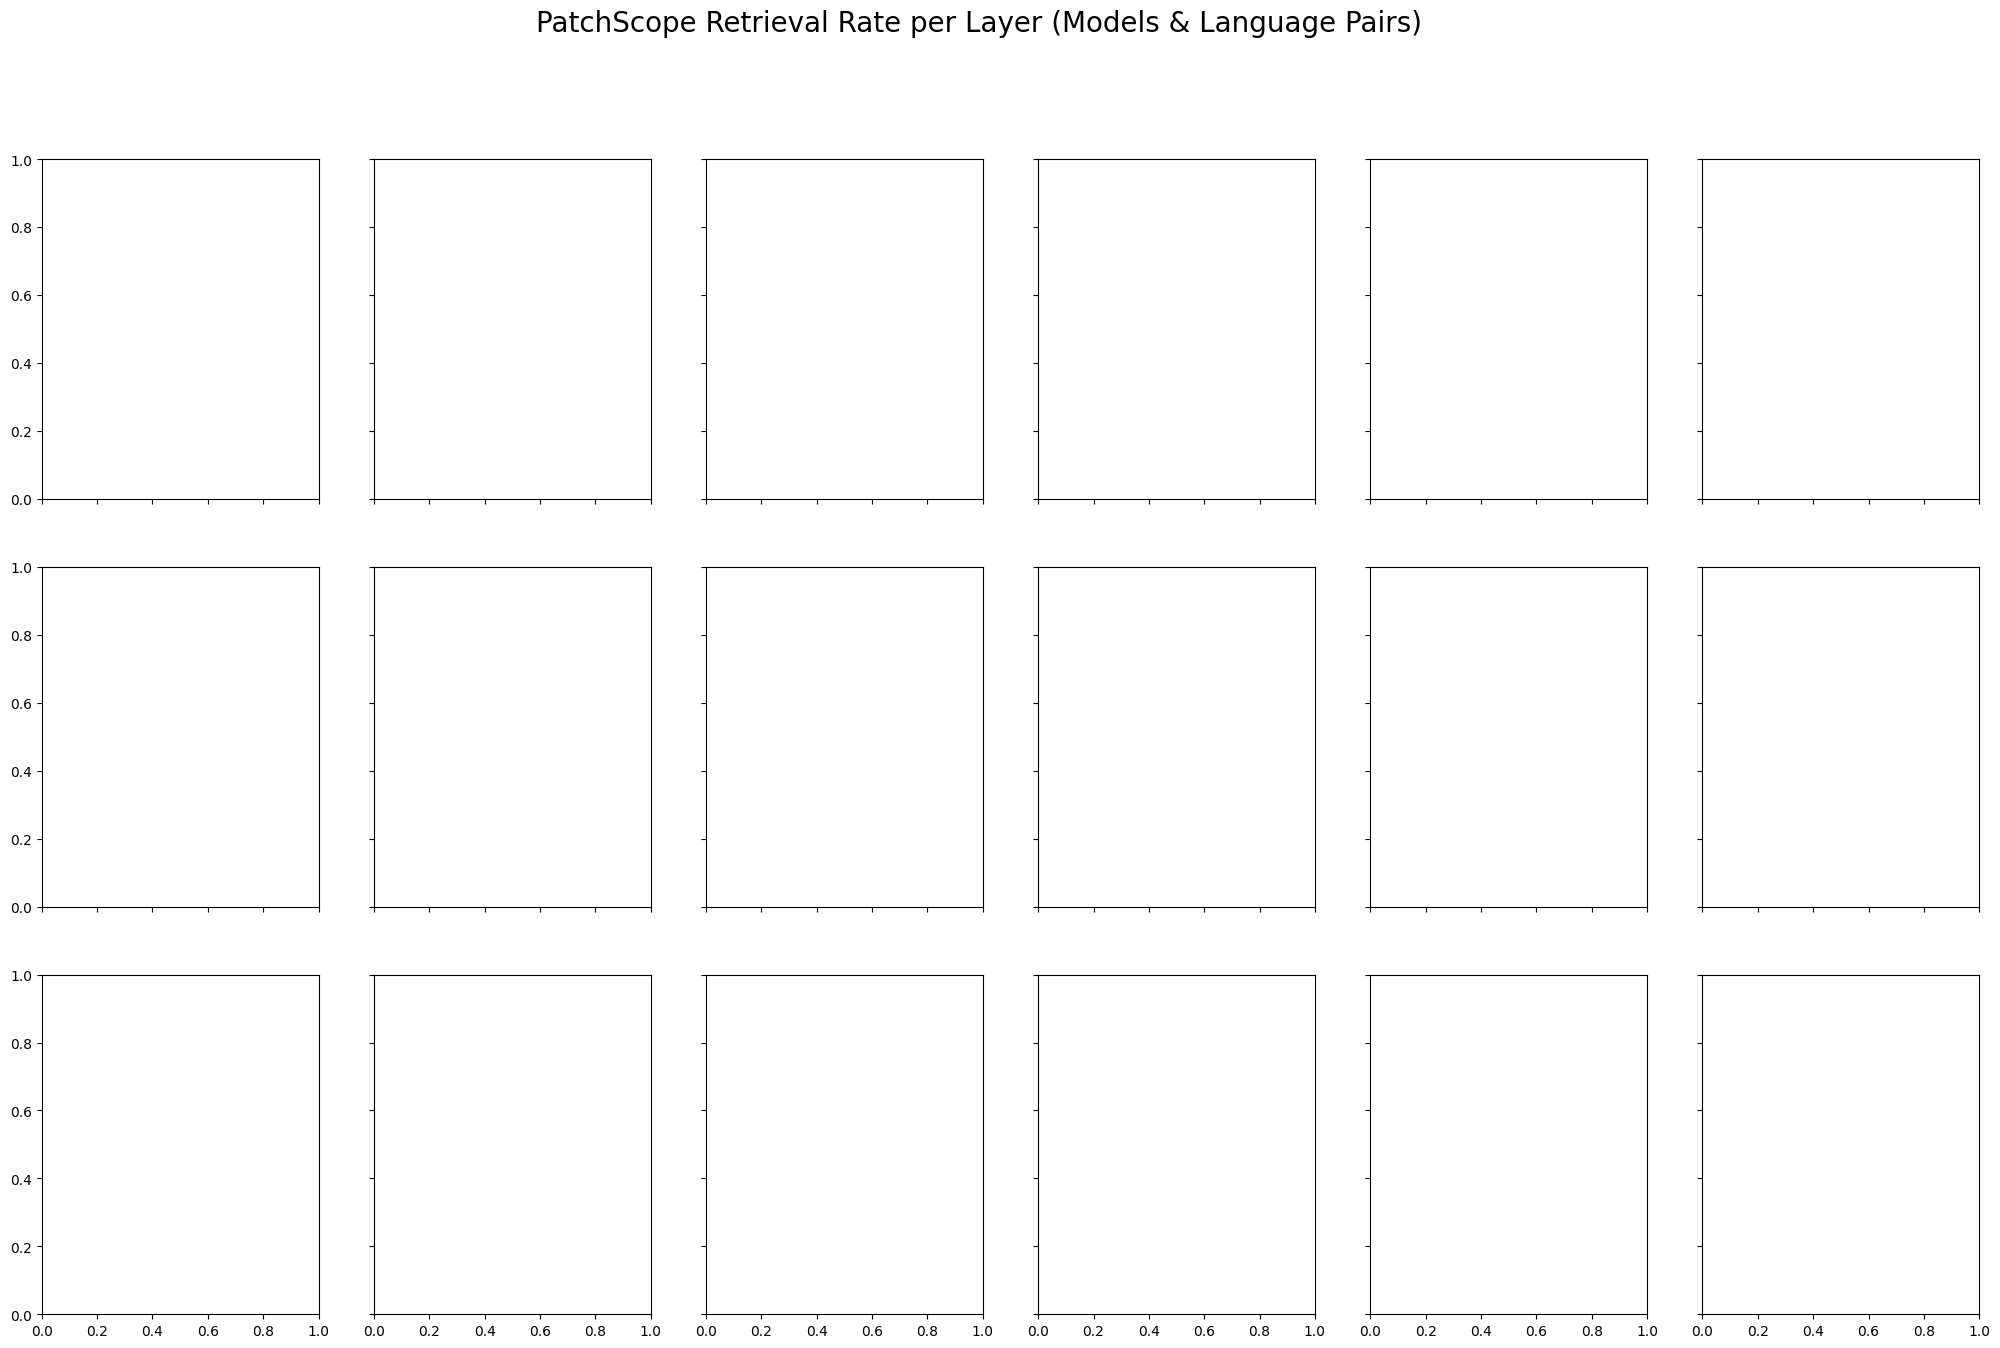

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval

# Define models, languages, and prompt versions
models = ["Tower-Babel/Babel-9B-Chat", "google/gemma-3-12b-it", "meta-llama/Llama-2-7b-chat-hf"]
languages = ["English", "Korean", "German"]
language_pairs = [(src, tgt) for src in languages for tgt in languages if src != tgt]

# Define colors and line styles for visualization

# Create subplots
fig, axes = plt.subplots(len(models), len(language_pairs), figsize=(25, 15), sharex=True, sharey=True)
fig.suptitle("PatchScope Retrieval Rate per Layer (Models & Language Pairs)", fontsize=20)

for i, model in enumerate(models):
    model_short = model.split("/")[-1]
    for j, (src, tgt) in enumerate(language_pairs):
        ax = axes[i, j]
        prompt_versions = [f"{src}Prompt", f"{tgt}Prompt"]
        for prompt_version in prompt_versions:
            # Load dataset
            data_df = pd.read_csv(f"/home/hyujang/multilingual-inner-lexicon/data/RQ2/MUSE/{src}_{tgt}_1000.csv")
            data_df[tgt] = data_df[tgt].apply(literal_eval)
            data_dict = dict(zip(data_df[src], data_df[tgt]))

            # Load output
            output_path = f"/home/hyujang/multilingual-inner-lexicon/output/RQ2/PatchScope/num_token_20/{model_short}_{src}_to_{tgt}_{prompt_version}_withOriginalCode.csv"
            output_df = pd.read_csv(output_path)
            output_df["patchscope_result"] = output_df["patchscope_result"].str.replace("\n", " ")

            # Compute retrieval rate

            # Apply matching
            output_df['retrieved'] = output_df.apply(
                lambda row: is_match(row['patchscope_result'], data_dict.get(row['word'], []), lang=tgt),
                axis=1
            )

            print(f"Processing {model_short} ({src}-{tgt}, {prompt_version})...")
            # print(output_df["patchscope_result"].value_counts().sort_values(ascending=False).head(10))
            
            value_counts = output_df["patchscope_result"].value_counts()

            n = 100
            count_over_n = (value_counts > n).sum()
            print(f"→ {count_over_n} unique answers occurred more than {n} times.")
            
            total = len(output_df)
            unique = output_df["patchscope_result"].nunique()
            duplicate_ratio = 1 - unique / total
            print(f"→ {duplicate_ratio:.2%} of outputs are duplicates.")

            top_k = 10
            top_k_total = value_counts.head(top_k).sum()
            print(f"→ Top {top_k} answers account for {top_k_total / total:.2%} of all outputs.")

            print()

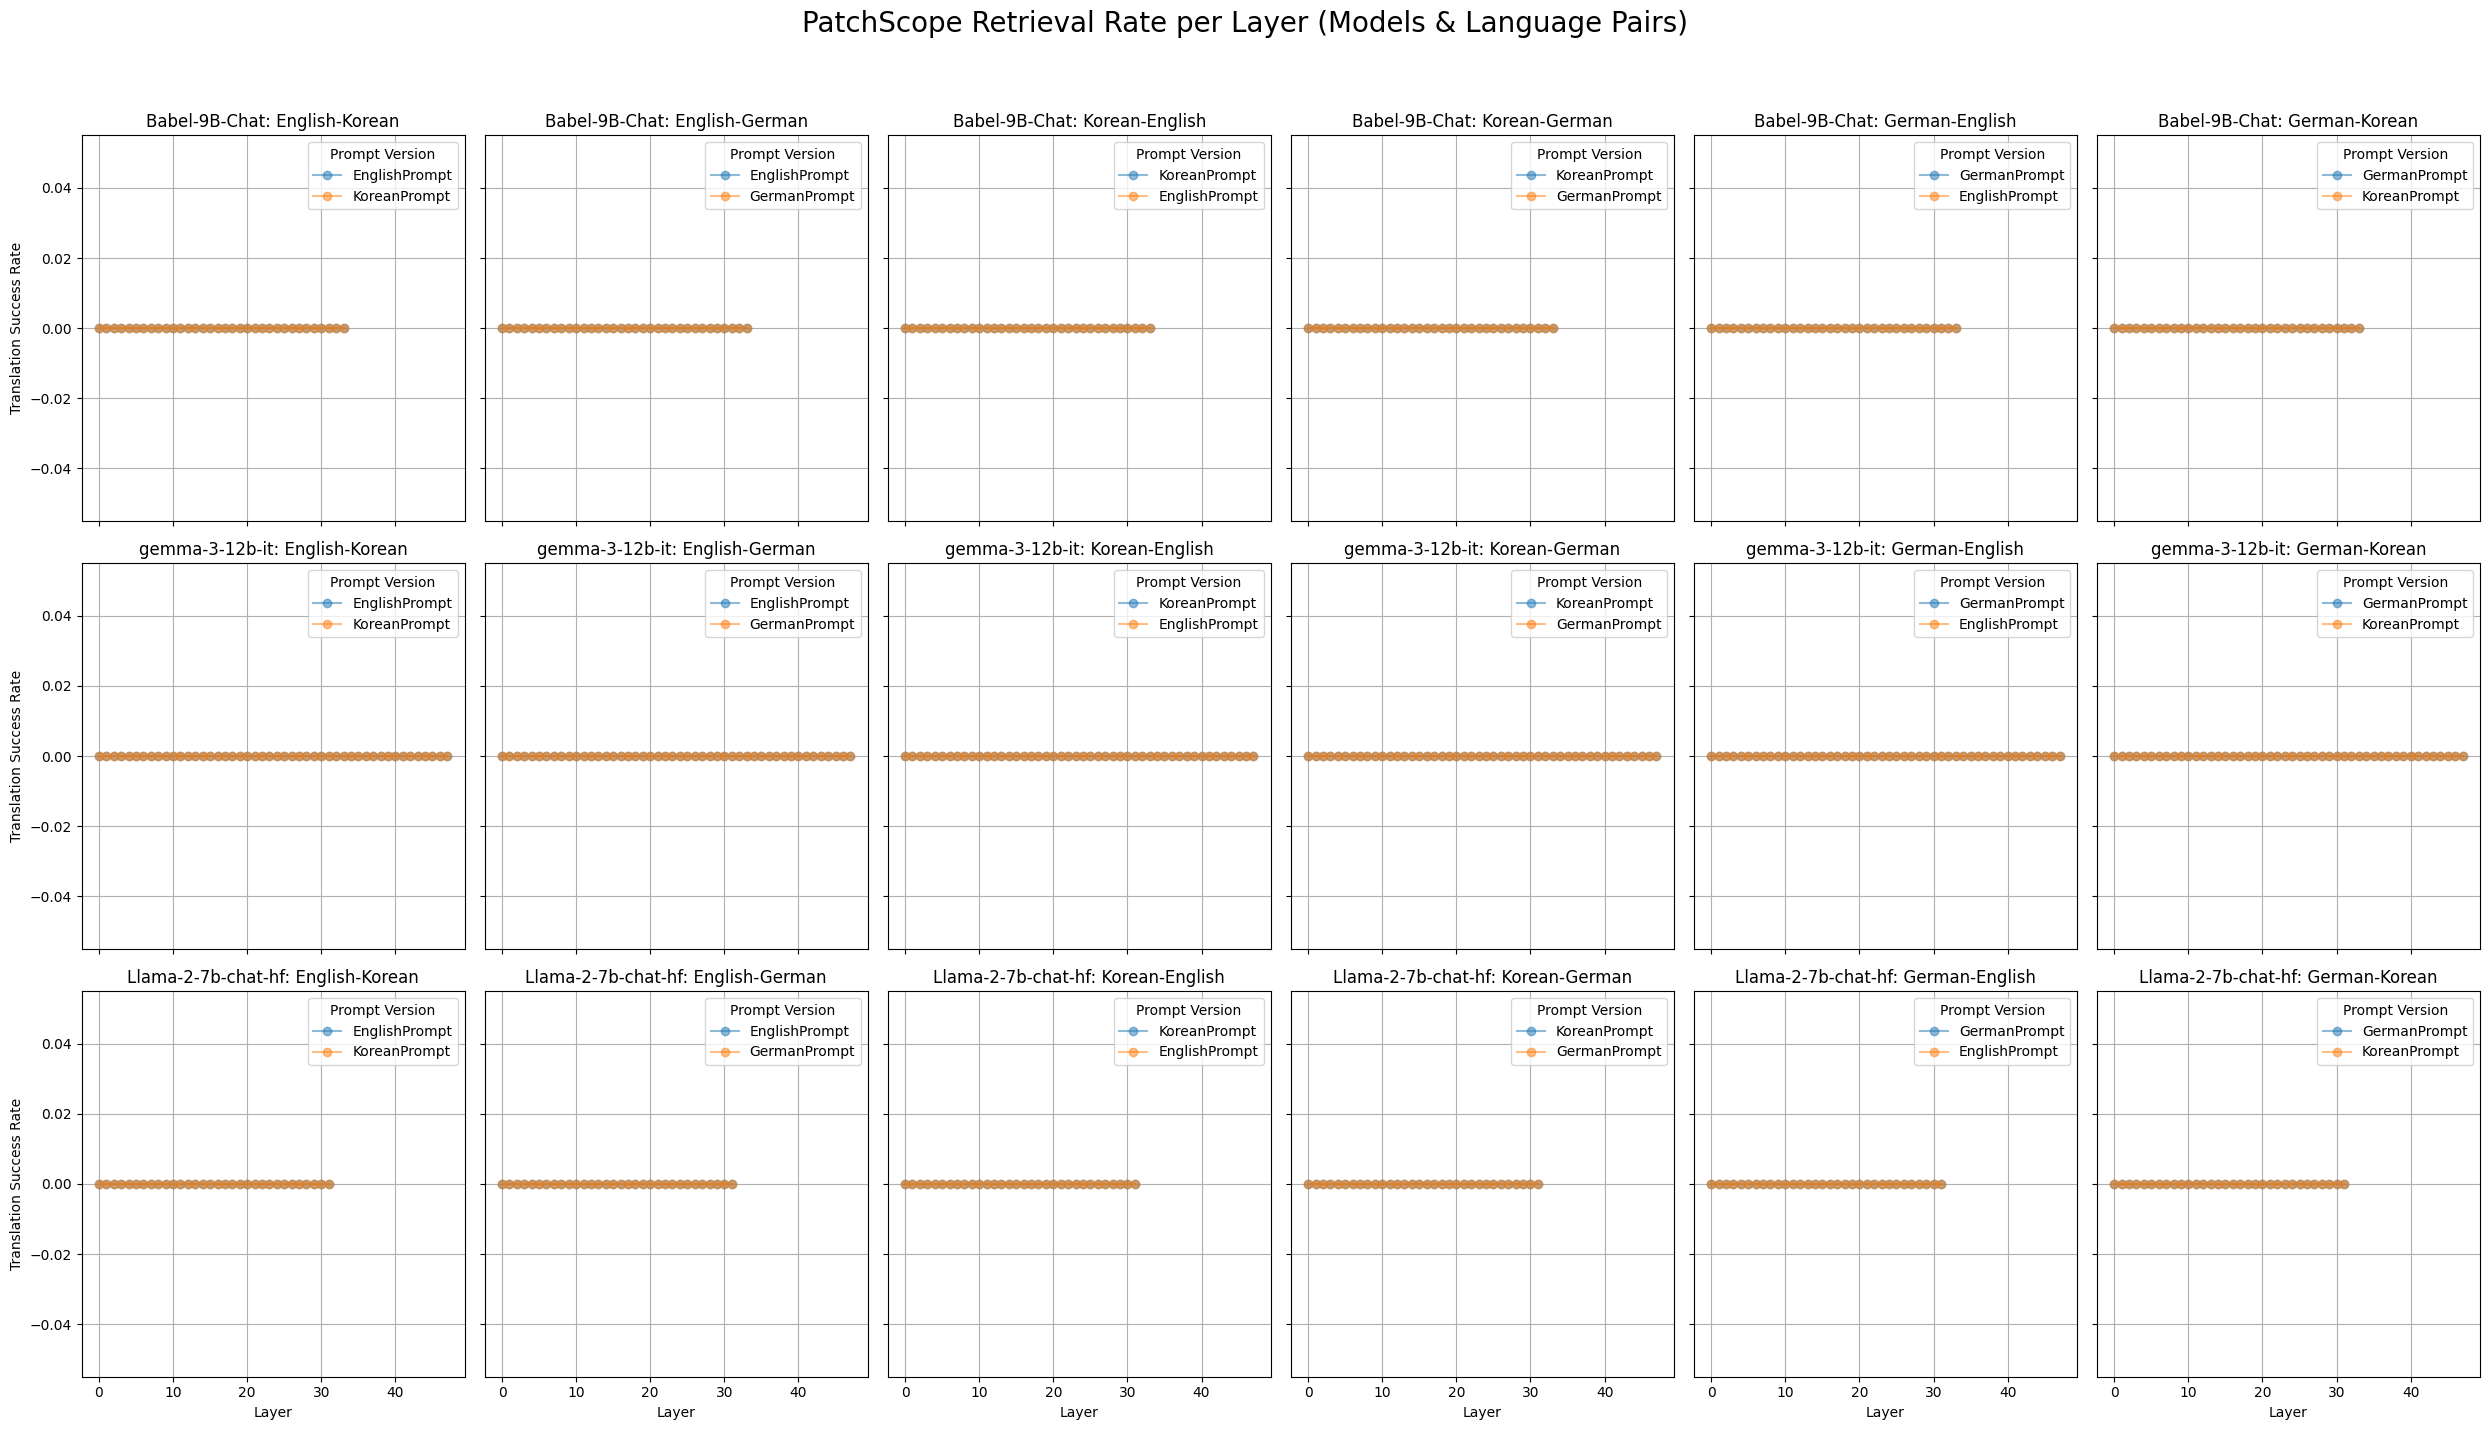

                 Model   Source   Target         Prompt  Total Outputs  \
2        Babel-9B-Chat  English   German  EnglishPrompt          34000   
3        Babel-9B-Chat  English   German   GermanPrompt          34000   
0        Babel-9B-Chat  English   Korean  EnglishPrompt          34000   
1        Babel-9B-Chat  English   Korean   KoreanPrompt          34000   
9        Babel-9B-Chat   German  English  EnglishPrompt          34000   
8        Babel-9B-Chat   German  English   GermanPrompt          34000   
10       Babel-9B-Chat   German   Korean   GermanPrompt          34000   
11       Babel-9B-Chat   German   Korean   KoreanPrompt          34000   
5        Babel-9B-Chat   Korean  English  EnglishPrompt          34000   
4        Babel-9B-Chat   Korean  English   KoreanPrompt          34000   
7        Babel-9B-Chat   Korean   German   GermanPrompt          34000   
6        Babel-9B-Chat   Korean   German   KoreanPrompt          34000   
26  Llama-2-7b-chat-hf  English   Germ

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval
from scipy.stats import entropy

# Define models, languages, and prompt versions
models = ["Tower-Babel/Babel-9B-Chat", "google/gemma-3-12b-it", "meta-llama/Llama-2-7b-chat-hf"]
languages = ["English", "Korean", "German"]
language_pairs = [(src, tgt) for src in languages for tgt in languages if src != tgt]

# Summary storage
summary_rows = []
TOP_K = 10
THRESHOLD = 100

# Create subplots
fig, axes = plt.subplots(len(models), len(language_pairs), figsize=(25, 15), sharex=True, sharey=True)
fig.suptitle("PatchScope Retrieval Rate per Layer (Models & Language Pairs)", fontsize=20)

for i, model in enumerate(models):
    model_short = model.split("/")[-1]
    for j, (src, tgt) in enumerate(language_pairs):
        ax = axes[i, j]
        prompt_versions = [f"{src}Prompt", f"{tgt}Prompt"]

        for prompt_version in prompt_versions:
            try:
                # Load dataset
                data_df = pd.read_csv(f"/home/hyujang/multilingual-inner-lexicon/data/RQ2/MUSE/{src}_{tgt}_1000.csv")
                data_df[tgt] = data_df[tgt].apply(literal_eval)
                data_dict = dict(zip(data_df[src], data_df[tgt]))

                # Load model output
                output_path = f"/home/hyujang/multilingual-inner-lexicon/output/RQ2/PatchScope/num_token_20/{model_short}_{src}_to_{tgt}_{prompt_version}_withOriginalCode.csv"
                output_df = pd.read_csv(output_path)
                output_df["patchscope_result"] = output_df["patchscope_result"].str.replace("\n", " ")

                # Compute repetition statistics
                value_counts = output_df["patchscope_result"].value_counts()
                total = len(output_df)
                unique = value_counts.count()
                duplicate_ratio = 1 - unique / total
                count_over_threshold = (value_counts > THRESHOLD).sum()
                top_k_total = value_counts.head(TOP_K).sum()
                top_k_ratio = top_k_total / total
                probabilities = value_counts / value_counts.sum()
                ent = entropy(probabilities, base=2)

                summary_rows.append({
                    "Model": model_short,
                    "Source": src,
                    "Target": tgt,
                    "Prompt": prompt_version,
                    "Total Outputs": total,
                    "Unique Outputs": unique,
                    "Duplicate Ratio": f"{duplicate_ratio:.2%}",
                    f"# Outputs >{THRESHOLD}": count_over_threshold,
                    f"Top {TOP_K} %": f"{top_k_ratio:.2%}",
                    "Entropy (bits)": round(ent, 2)
                })

                # Optional: dummy retrieval check if needed
                output_df['retrieved'] = False  # or apply your match logic here

                # Plot retrieval rate if retrieved column is used
                if 'layer' in output_df.columns:
                    retrieval_rate_by_layer = output_df.groupby('layer')['retrieved'].mean()
                    ax.plot(
                        retrieval_rate_by_layer.index,
                        retrieval_rate_by_layer.values,
                        marker='o',
                        label=f"{prompt_version}",
                        alpha=0.5,
                    )

            except FileNotFoundError:
                print(f"File not found for {model_short} ({src}-{tgt}, {prompt_version})")
                continue

        ax.set_title(f"{model_short}: {src}-{tgt}")
        if i == len(models) - 1:
            ax.set_xlabel("Layer")
        if j == 0:
            ax.set_ylabel("Translation Success Rate")
        ax.grid(True)
        ax.legend(title="Prompt Version")

# Plot formatting
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Create and save summary table
summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.sort_values(by=["Model", "Source", "Target", "Prompt"])
print(summary_df)

# Save to CSV
# summary_df.to_csv("output_repetition_summary.csv", index=False)


In [51]:
summary_df.to_csv("output_repetition_summary.csv", index=False)

## visualize all for a single language pair

Data file for Babel-9B-Chat with KoreanPrompt not found. Skipping...


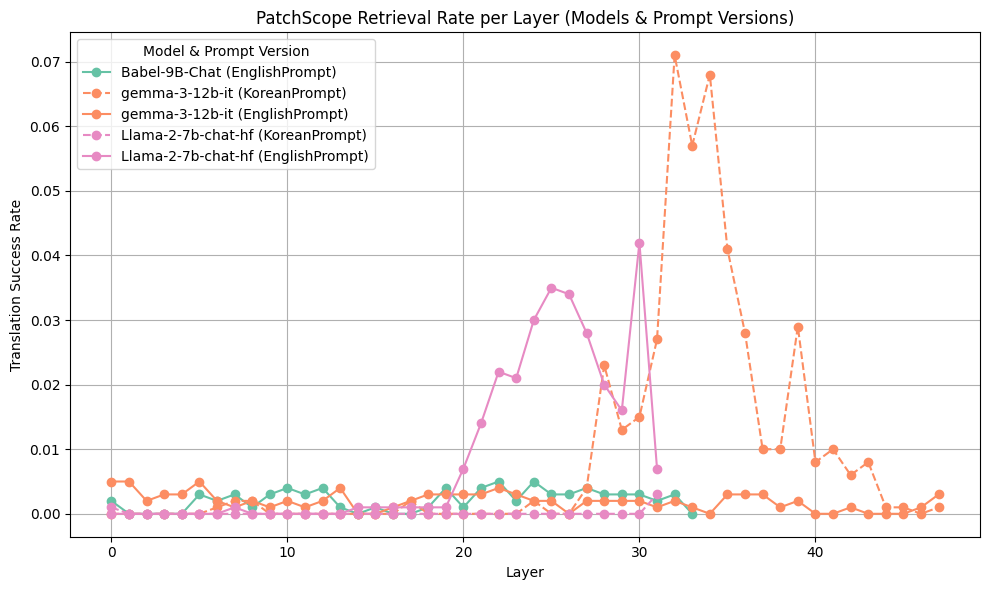

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval

SOURCE_LANGUAGE = "Korean"
TARGET_LANGUAGE = "English"

# Define models and prompt versions
models = ["Tower-Babel/Babel-9B-Chat", "google/gemma-3-12b-it", "meta-llama/Llama-2-7b-chat-hf"]
prompt_versions = [f"{SOURCE_LANGUAGE}Prompt", f"{TARGET_LANGUAGE}Prompt"]

# Define colors and line styles for visualization
model_colors = {
    "Babel-9B-Chat": "#66c2a5",
    "gemma-3-12b-it": "#fc8d62",
    "Llama-2-7b-chat-hf": "#e78ac3"
}
prompt_styles = {
    f"{SOURCE_LANGUAGE}Prompt": "--",
    f"{TARGET_LANGUAGE}Prompt": "-"
}

plt.figure(figsize=(10, 6))

# Iterate through models and prompt versions
for model in models:
    model_short = model.split("/")[-1]
    for prompt_version in prompt_versions:
        try:
            data_df = pd.read_csv(f"/home/hyujang/multilingual-inner-lexicon/data/RQ2/MUSE/{SOURCE_LANGUAGE}_{TARGET_LANGUAGE}_1000.csv")
            data_df[f"{TARGET_LANGUAGE}"] = data_df[f"{TARGET_LANGUAGE}"].apply(literal_eval)
            data_dict = dict(zip(data_df[f"{SOURCE_LANGUAGE}"], data_df[f"{TARGET_LANGUAGE}"]))
            
            output_df = pd.read_csv(f"/home/hyujang/multilingual-inner-lexicon/output/RQ2/PatchScope/{model_short}_{SOURCE_LANGUAGE}_to_{TARGET_LANGUAGE}_{prompt_version}.csv")
            output_df["patchscope_result"] = output_df["patchscope_result"].str.replace("\n"," ")
            
            output_df['retrieved'] = output_df.apply(
                lambda row: any(value in str(row['patchscope_result']) for value in data_dict.get(row['word'], [])),
                axis=1
            )

            retrieval_rate_by_layer = output_df.groupby('layer')['retrieved'].mean()
            
            # Plot retrieval rate
            plt.plot(
                retrieval_rate_by_layer.index,
                retrieval_rate_by_layer.values,
                marker='o',
                label=f"{model_short} ({prompt_version})",
                color=model_colors.get(model_short, "black"),
                linestyle=prompt_styles.get(prompt_version, "-")
            )
        except FileNotFoundError:
            print(f"Data file for {model_short} with {prompt_version} not found. Skipping...")

# Add labels, title, and legend
plt.xlabel("Layer")
plt.ylabel("Translation Success Rate")
plt.title("PatchScope Retrieval Rate per Layer (Models & Prompt Versions)")
plt.grid(True)
plt.legend(title="Model & Prompt Version")
plt.tight_layout()
plt.show()

## visualize a single result

In [4]:
output_df['retrieved'] = output_df.apply(
    lambda row: any(value in str(row['patchscope_result']) for value in data_dict.get(row['word'], [])),
    axis=1
)

In [12]:
output_df = pd.read_csv(f"/home/hyujang/multilingual-inner-lexicon/output/RQ2/PatchScope/{MODEL_NAME}_{SOURCE_LANGUAGE}_to_{TARGET_LANGUAGE}_KoreanPrompt_withOriginalCode.csv")
output_df["patchscope_result"].value_counts()

patchscope_result
\n\n* **[word    48000
Name: count, dtype: int64

In [26]:
output_df

,word,layer,patchscope_result,retrieved
0,barman,0,der Mann Here,False
1,barman,1,* **der Mann,False
2,barman,2,* **der Bark,False
3,barman,3,* **Bark,False
4,barman,4,* **Bark,False
...,...,...,...,...
47995,sunken,43,a) das Haus,False
47996,sunken,44,a) das Haus,False
47997,sunken,45,a) das Haus,False
47998,sunken,46,a) das Haus,False


In [25]:
output_df[output_df["retrieved"]]["patchscope_result"]

1509       a) abwenden
1824         *   **wie
1825         *   **wie
1826         *   **wie
1827         *   **wie
             ...      
47616      *   **heben
47617      *   **heben
47618      *   **heben
47619      *   **heben
47625      *   **heben
Name: patchscope_result, Length: 395, dtype: object

['avert' 'like' 'find' 'quieter' 'praiseworthy' 'told' 'working'
 'nonetheless' 'escaped' 'pink' 'antisemitism' 'preach' 'windy' 'soothing'
 'widowed' 'eaten' 'measurable' 'sick' 'recuperation' 'analogue'
 'tolerate' 'carefree' 'trace' 'hired' 'simplifies' 'peppermint' 'thick'
 'immature' 'long' 'never' 'ringing' 'denture' 'thirteen' 'lend' 'lied'
 'greatest' 'peaceful' 'set' 'tough' 'impact' 'diving' 'intoxicating'
 'stringent' 'valuable' 'will' 'bold' 'incorrect' 'fewer' 'headquarter'
 'forgetting' 'susceptible' 'declaring' 'stuffed' 'parenchyma' 'sleepy'
 'recognize' 'jester' 'destroying' 'erect' 'rainier' 'deserves'
 'illuminate' 'passionate' 'cooked' 'naughty' 'queer' 'knit' 'collaborate'
 'concave' 'com' 'conditional' 'nicer' 'trot' 'equatorial' 'thousand'
 'trust' 'grasp' 'reserved' 'lifting']


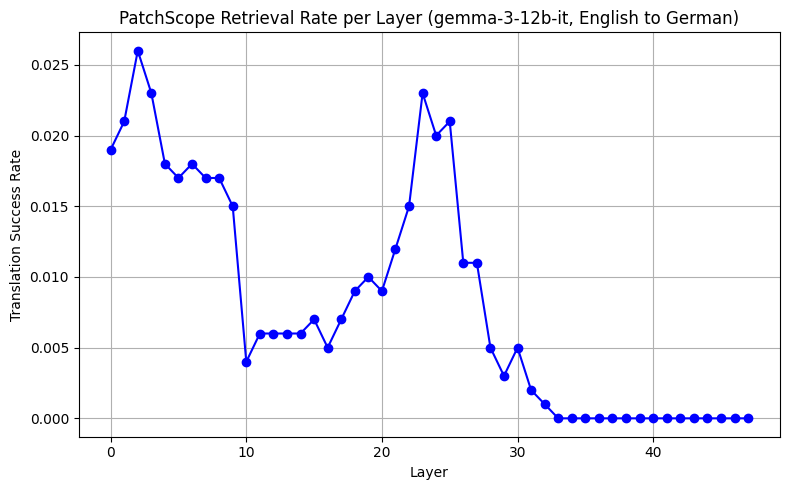

In [24]:
import pandas as pd
from ast import literal_eval

SOURCE_LANGUAGE = "English"
TARGET_LANGUAGE = "German"
MODEL_NAME = "google/gemma-3-12b-it"
# MODEL_NAME = "meta-llama/Llama-2-7b-chat-hf"
# MODEL_NAME = "Tower-Babel/Babel-9B-Chat"
MODEL_NAME = MODEL_NAME.split("/")[-1]  # Extract model name for output file

data_df = pd.read_csv(f"/home/hyujang/multilingual-inner-lexicon/data/RQ2/MUSE/{SOURCE_LANGUAGE}_{TARGET_LANGUAGE}_1000.csv")
data_df[f"{TARGET_LANGUAGE}"] = data_df[f"{TARGET_LANGUAGE}"].apply(literal_eval)
output_df = pd.read_csv(f"/home/hyujang/multilingual-inner-lexicon/output/RQ2/PatchScope/{MODEL_NAME}_{SOURCE_LANGUAGE}_to_{TARGET_LANGUAGE}_EnglishPrompt_withOriginalCode.csv")
output_df["patchscope_result"] = output_df["patchscope_result"].str.replace("\n"," ")
data_dict = dict(zip(data_df[f"{SOURCE_LANGUAGE}"], data_df[f"{TARGET_LANGUAGE}"]))
output_df['retrieved'] = output_df.apply(
    lambda row: any(value in str(row['patchscope_result']) for value in data_dict.get(row['word'], [])),
    axis=1
)

retrieval_rate = output_df['retrieved'].mean()

# print(output_df[output_df['retrieved']]["word"].value_counts())
print(output_df[output_df['retrieved']]["word"].unique())
en_prompt_true_list = output_df[output_df['retrieved']]["word"].unique()

import matplotlib.pyplot as plt
# Group by layer and compute retrieval rate
retrieval_rate_by_layer = output_df.groupby('layer')['retrieved'].mean()

# Plot the retrieval rate
plt.figure(figsize=(8, 5))
plt.plot(retrieval_rate_by_layer.index, retrieval_rate_by_layer.values, marker='o', linestyle='-', color='b')
plt.xlabel("Layer")
plt.ylabel("Translation Success Rate")
plt.title(f"PatchScope Retrieval Rate per Layer ({MODEL_NAME}, {SOURCE_LANGUAGE} to {TARGET_LANGUAGE})")
plt.grid(True)
plt.tight_layout()
plt.show()

['리허설' '침공' '종속' '평점' '대포' '누락' '스쿠터' '아르카나' '안테나' '이구아나' '테러리스트' '윤곽'
 '호출' '관리자' '스릴러' '수분' '순수' '음절' '해산물' '교회' '베이글' '체인' '보상' '예방' '커머스'
 '대리인' '이끼' '세균' '머리카락' '리튬' '히터' '남동' '컨버터블' '절약' '민주주의' '모퉁이' '비서' '형제'
 '예고편' '복합체' '평생' '가운' '보일러' '달빛' '발라드' '부재' '머리' '그릇' '안마' '섀도' '센스' '런칭'
 '자료' '위엄' '위임' '레지던스' '장례식' '친척' '시프트' '터치스크린' '모션' '결막염' '항공' '사춘기'
 '전화번호' '소녀' '작가' '필터' '근사' '영장' '눈꺼풀' '접근법' '커리어' '조사' '태양광' '차량' '사진'
 '풋볼' '파울' '품목' '캐주얼' '부호' '딜러' '오디오' '전설' '보너스' '반역자' '계기' '재활' '연주회'
 '리턴' '레전드' '트라우마' '계절' '겸손' '질량' '압력' '슈퍼맨' '안보' '신고' '프로그램' '시럽' '청소부'
 '캐러밴' '납득' '광학' '백내장' '협곡' '남용' '도시' '호위' '메커니즘' '댄스' '레스토랑' '컨트롤러' '소변'
 '매치' '특수' '전극' '국방' '인턴십' '초원' '암초' '결혼' '발발' '소외' '익사' '벤처' '침투' '사상자'
 '피시' '젓가락' '희귀' '미션' '칵테일' '클럽하우스' '캠퍼스' '오션' '볼트' '고무' '감정' '사멸' '두려움'
 '비교' '카푸치노' '보건' '마커' '굴욕' '점령' '나이트클럽' '장치' '다이어그램' '중성자' '사실' '럼블' '부츠'
 '삼각형' '통제' '픽셀' '거의' '프로그래밍' '진흙' '직통' '계절풍' '게임' '위선' '수확' '추구' '보호'
 '복사기' '평범' '맞춤법' '리포터' '도자기' '라이브러리' '귀신' '진정제' '플럭스' '봉

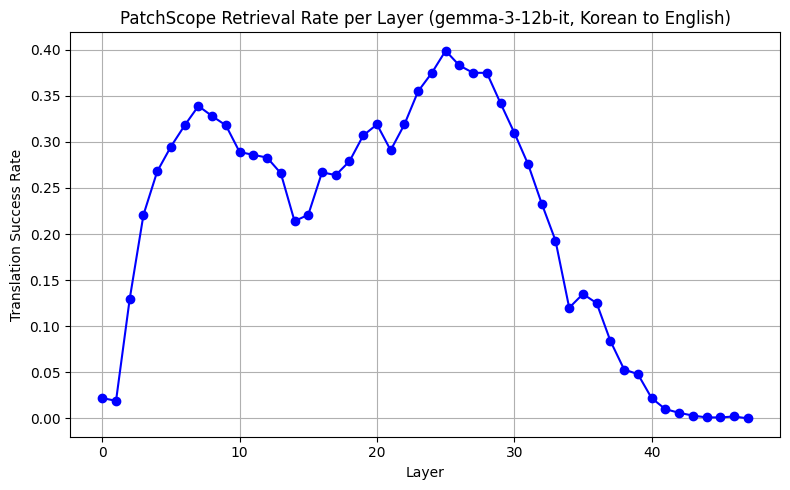

In [14]:
import pandas as pd
from ast import literal_eval

SOURCE_LANGUAGE = "Korean"
TARGET_LANGUAGE = "English"
MODEL_NAME = "google/gemma-3-12b-it"
# MODEL_NAME = "meta-llama/Llama-2-7b-chat-hf"
# MODEL_NAME = "Tower-Babel/Babel-9B-Chat"
MODEL_NAME = MODEL_NAME.split("/")[-1]  # Extract model name for output file

data_df = pd.read_csv(f"/home/hyujang/multilingual-inner-lexicon/data/RQ2/MUSE/{SOURCE_LANGUAGE}_{TARGET_LANGUAGE}_1000.csv")
data_df[f"{TARGET_LANGUAGE}"] = data_df[f"{TARGET_LANGUAGE}"].apply(literal_eval)
output_df = pd.read_csv(f"/home/hyujang/multilingual-inner-lexicon/output/RQ2/PatchScope/{MODEL_NAME}_{SOURCE_LANGUAGE}_to_{TARGET_LANGUAGE}_KoreanPrompt_withOriginalCode_v2.csv")
output_df["patchscope_result"] = output_df["patchscope_result"].str.replace("\n"," ")
data_dict = dict(zip(data_df[f"{SOURCE_LANGUAGE}"], data_df[f"{TARGET_LANGUAGE}"]))
output_df['retrieved'] = output_df.apply(
    lambda row: any(value in str(row['patchscope_result']) for value in data_dict.get(row['word'], [])),
    axis=1
)

retrieval_rate = output_df['retrieved'].mean()

# print(output_df[output_df['retrieved']]["word"].value_counts())
print(output_df[output_df['retrieved']]["word"].unique())
en_prompt_true_list = output_df[output_df['retrieved']]["word"].unique()

import matplotlib.pyplot as plt
# Group by layer and compute retrieval rate
retrieval_rate_by_layer = output_df.groupby('layer')['retrieved'].mean()

# Plot the retrieval rate
plt.figure(figsize=(8, 5))
plt.plot(retrieval_rate_by_layer.index, retrieval_rate_by_layer.values, marker='o', linestyle='-', color='b')
plt.xlabel("Layer")
plt.ylabel("Translation Success Rate")
plt.title(f"PatchScope Retrieval Rate per Layer ({MODEL_NAME}, {SOURCE_LANGUAGE} to {TARGET_LANGUAGE})")
plt.grid(True)
plt.tight_layout()
plt.show()

## visualize specific files

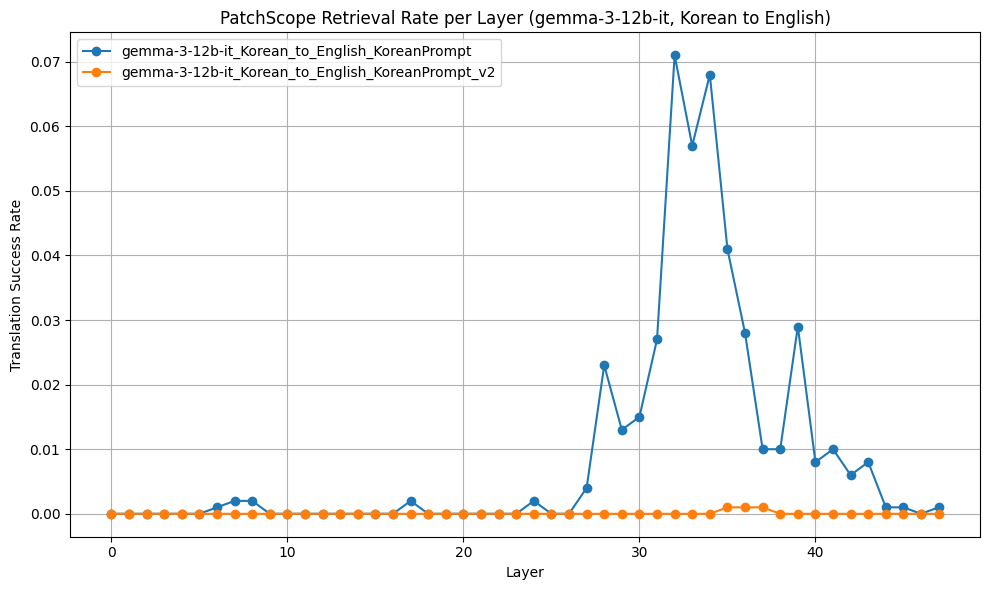

In [93]:
MODEL_NAME = "gemma-3-12b-it"

output_paths = [f"/home/hyujang/multilingual-inner-lexicon/output/RQ2/PatchScope/{MODEL_NAME}_{SOURCE_LANGUAGE}_to_{TARGET_LANGUAGE}_KoreanPrompt.csv", 
                f"/home/hyujang/multilingual-inner-lexicon/output/RQ2/PatchScope/{MODEL_NAME}_{SOURCE_LANGUAGE}_to_{TARGET_LANGUAGE}_KoreanPrompt_v2.csv",
                # f"/home/hyujang/multilingual-inner-lexicon/output/RQ2/PatchScope/{MODEL_NAME}_{SOURCE_LANGUAGE}_to_{TARGET_LANGUAGE}_v3.csv"
                ]


plt.figure(figsize=(10, 6))

for output_path in output_paths:
    data_df = pd.read_csv(f"/home/hyujang/multilingual-inner-lexicon/data/RQ2/MUSE/{SOURCE_LANGUAGE}-{TARGET_LANGUAGE}_1000.csv")
    data_df[f"{TARGET_LANGUAGE}"] = data_df[f"{TARGET_LANGUAGE}"].apply(literal_eval)
    output_df = pd.read_csv(output_path)
    output_df["patchscope_result"] = output_df["patchscope_result"].str.replace("\n"," ")
    data_dict = dict(zip(data_df[f"{SOURCE_LANGUAGE}"], data_df[f"{TARGET_LANGUAGE}"]))
    output_df['retrieved'] = output_df.apply(
        lambda row: any(value in str(row['patchscope_result']) for value in data_dict.get(row['word'], [])),
        axis=1
    )

    retrieval_rate_by_layer = output_df.groupby('layer')['retrieved'].mean()
    # print(f"{output_path.split('/')[-1]}")
    plt.plot(
    retrieval_rate_by_layer.index,
    retrieval_rate_by_layer.values,
    marker='o',
    # label="hi"
    label=f"{output_path.split('/')[-1].replace(".csv","")}",  # Use the file name as label
    # color=language_colors.get(lang, "black"),  # Use the color for the language
    # linestyle=model_styles.get(model_short, "dashdot"),  # Use the line style for the model
        )


plt.xlabel("Layer")
plt.ylabel("Translation Success Rate")
plt.title(f"PatchScope Retrieval Rate per Layer ({MODEL_NAME}, {SOURCE_LANGUAGE} to {TARGET_LANGUAGE})")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()